# Notebook to analyze data with interactive graphs

First we need to load all the packages necessary for this notebook. In order to install the packages run pip install requirements.txt

In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import os

Next we get the data using the environment variable ```RESEARCH_DATA_PATH``` which should direct to the data folder of this project

In [210]:
# Get the path to the data folder
DATA_PATH = os.environ.get("RESEARCH_DATA_PATH")

# Load the csv files created by the process.py script
gdp_data = pd.read_csv(f'{DATA_PATH}/processed/clean_gdp_data.csv').rename(columns = {'value': 'us_gdp'})
spy_data = pd.read_csv(f'{DATA_PATH}/processed/clean_stock_data.csv')[['date', 'adjusted_close']].rename(columns = {'adjusted_close': 'sp500'})

# Format the date columns as datetime and set them as index column
gdp_data['date'] = gdp_data['date'].apply(pd.to_datetime)
gdp_data.set_index('date', inplace=True)
spy_data['date'] = spy_data['date'].apply(pd.to_datetime)
spy_data.set_index('date', inplace=True)

# Join the data and calculate the percentage growths
close_data = gdp_data.join(spy_data).sort_index()
data = close_data.join(close_data.pct_change(1).rename(columns = {'us_gdp': 'us_gdp_growth', 'sp500': 'sp500_growth'})).sort_index()

In [211]:
data

,us_gdp,sp500,us_gdp_growth,sp500_growth
date,,,,
2002-01-01,3263.869,76.9760,NaN,NaN
2002-04-01,3362.508,77.3430,0.030221,0.004768
2002-07-01,3401.820,67.0722,0.011691,-0.132795
2002-10-01,3460.159,55.6833,0.017149,-0.169801
2003-01-01,3340.163,60.3587,-0.034679,0.083964
...,...,...,...,...
2021-04-01,4890.835,387.8659,0.042461,0.063524
2021-07-01,4916.402,420.3074,0.005228,0.083641
2021-10-01,5110.951,422.7312,0.039571,0.005767


In [212]:
# Write a latex label with summary statistics

data_info = data.describe()
data_info.columns = ['US GDP','S&P 500', 'GDP Growth', 'S&P Growth']

with open('../reports/tables/summary_statistics.tex','w') as tf:
    tf.write(data_info.style.to_latex())

data_info

,US GDP,S&P 500,GDP Growth,S&P Growth
count,82.000000,82.000000,81.000000,81.000000
mean,4128.130902,160.363667,0.005655,0.025347
std,452.128214,101.007931,0.028764,0.081543
min,3263.869000,55.683300,-0.063206,-0.215656
25%,3824.748500,87.515150,-0.022593,-0.003756
50%,4036.640500,112.793800,0.015098,0.035528
75%,4487.537250,211.112000,0.026021,0.070540
max,5110.951000,469.528800,0.084225,0.201649


In [213]:
# What is the correlation between the two variables

data[['us_gdp', 'sp500']].corr()

,us_gdp,sp500
us_gdp,1.000000,0.908775
sp500,0.908775,1.000000


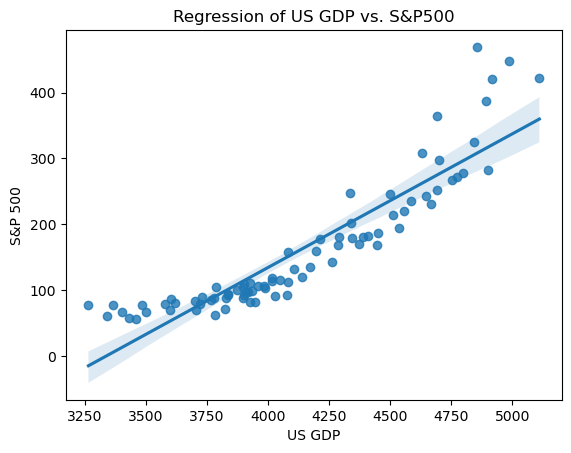

In [243]:
fig = sns.regplot(x=data.us_gdp, y=data.sp500).set(xlabel='US GDP', ylabel='S&P 500', title='Regression of US GDP vs. S&P500');

plt.savefig("../reports/figures/regression.svg")

In [214]:
# Make the two series to start at 100

data_ext = data.copy()

data_ext['us_gdp_100'] = 100*np.exp(np.nan_to_num(data['us_gdp_growth'].cumsum()))
data_ext['sp500_100'] = 100*np.exp(np.nan_to_num(data['sp500_growth'].cumsum()))

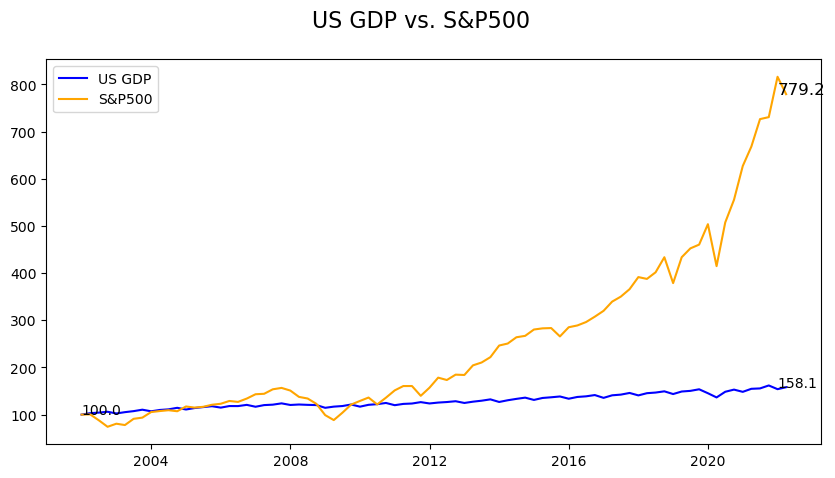

In [215]:
# Plot the two series both starting at 100

fig1, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(data_ext.us_gdp_100, color='blue')
ax1.plot(data_ext.sp500_100, color='orange')

fig1.suptitle('US GDP vs. S&P500', fontsize=16)

ax1.legend(['US GDP', 'S&P500'], loc='upper left');

ax1.text(data_ext.us_gdp_100.index[-2], data_ext.us_gdp_100[-1], np.round(data_ext.us_gdp_100[-1], 1))
ax1.text(data_ext.sp500_100.index[-2], data_ext.sp500_100[-1], np.round(data_ext.sp500_100[-1], 1), size=12)
ax1.text(data_ext.sp500_100.index[0], data_ext.sp500_100[0], np.round(data_ext.sp500_100[0], 1))

plt.savefig("../reports/figures/growth_starting_at_100.svg")

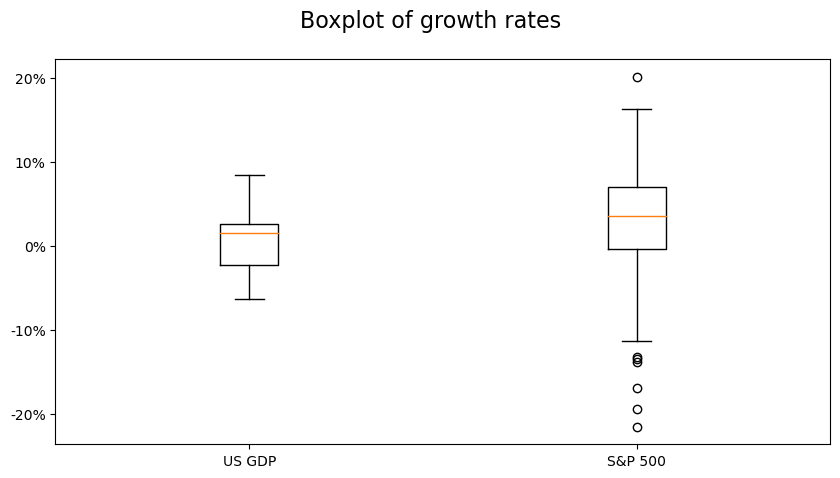

In [216]:
# Add some boxplots

fig2, ax2 = plt.subplots(figsize=(10, 5))
fig2.suptitle('Boxplot of growth rates', fontsize=16)
ax2.boxplot(data[['us_gdp_growth', 'sp500_growth']].dropna())
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax2.set_xticks([1, 2], ['US GDP', 'S&P 500']);

plt.savefig("../reports/figures/boxplots.svg")

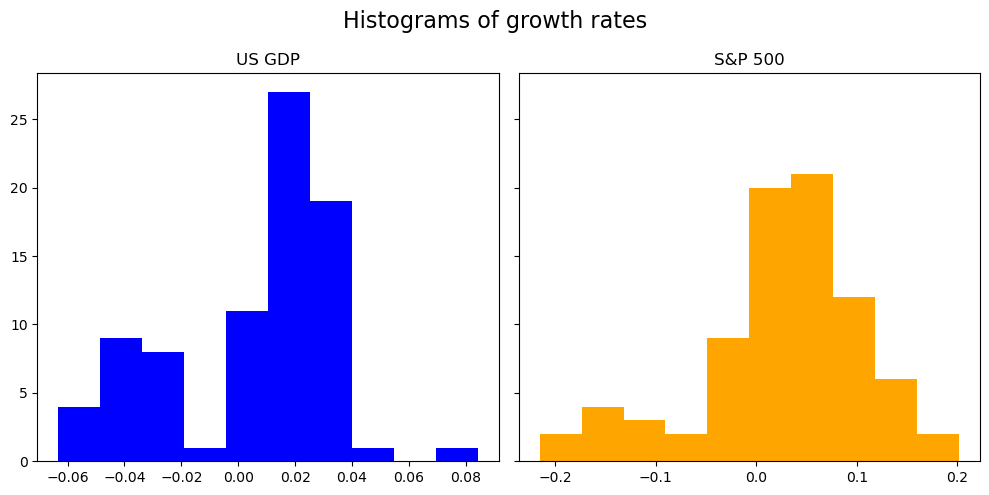

In [217]:
# Add some histograms

fig3, ax3 = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True, tight_layout=True)
fig3.suptitle('Histograms of growth rates', fontsize=16)

ax3[0].set_title('US GDP')
ax3[1].set_title('S&P 500')

ax3[0].hist(data.us_gdp_growth, color = 'blue')
ax3[1].hist(data.sp500_growth, color = 'orange');

plt.savefig("../reports/figures/histograms.svg")

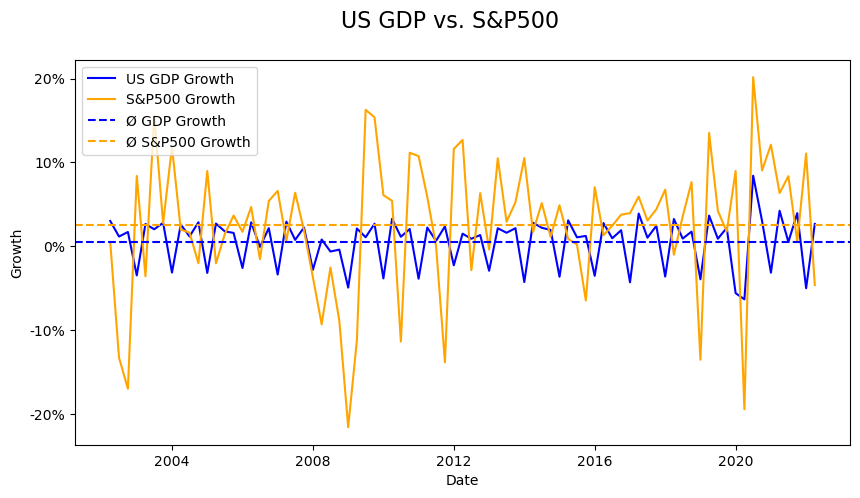

In [218]:
# Plot the growth rates and the average growth over that period

fig4, ax4 = plt.subplots(figsize=(10, 5))

ax4.plot(data.us_gdp_growth, color='blue')
ax4.plot(data.sp500_growth, color='orange')

ax4.axhline(y=np.nanmean(data.us_gdp_growth), color='blue', linestyle='dashed')
ax4.axhline(y=np.nanmean(data.sp500_growth), color='orange', linestyle='dashed')

ax4.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
fig4.suptitle('US GDP vs. S&P500', fontsize=16)
ax4.set_ylabel('Growth')
ax4.set_xlabel('Date')
ax4.legend(['US GDP Growth', 'S&P500 Growth', 'Ø GDP Growth', 'Ø S&P500 Growth'], loc='upper left');

plt.savefig("../reports/figures/average_growth.svg")